In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import warnings, sys, subprocess, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

# ----- Ensure xgboost available -----
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "xgboost"], check=False)
    import xgboost as xgb
    from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression


In [4]:
import pandas as pd

# Kaggle path (must include filename)
CSV_PATH = "/kaggle/input/credit-card-default-synthetic-data/UCI_Syncora_Synthetic(in).csv"

try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    # Fallback if running locally
    CSV_PATH = "/mnt/data/UCI_Syncora_Synthetic(in).csv"
    df = pd.read_csv(CSV_PATH)

# Preview
print(df.shape)
print(df.head())


(49999, 25)
   Unnamed: 0     LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  \
0           0   44893.65031    1          2         2   40      0      0   
1           1   18424.51910    1          2         2   21      0      0   
2           2  117876.94280    1          3         2   50      0      0   
3           3   54723.37793    2          2         2   30      0      0   
4           4   76558.09426    2          3         1   54      0      0   

   PAY_3  PAY_4  ...     BILL_AMT4     BILL_AMT5     BILL_AMT6     PAY_AMT1  \
0      0      0  ...   39360.39944   41649.50081   45785.83597   676.382844   
1      2      2  ...   26782.29535   19924.71962   21855.94097  3242.199560   
2      0      2  ...  116157.18960  119962.73580  120028.66750  5274.265065   
3      0      0  ...   38065.93017   41540.05863   41878.68588  3270.158117   
4      0      0  ...   45179.78846   44981.27741   45357.86824  4672.139378   

      PAY_AMT2     PAY_AMT3     PAY_AMT4     PAY_AMT5   

In [5]:
# Detect target: prefer a column containing 'default', else last column
target_candidates = [c for c in df.columns if "default" in c.lower()]
TARGET = target_candidates[0] if target_candidates else df.columns[-1]
print(f"\nTarget column detected: {TARGET}")
print("\nMissing values (top 10):\n", df.isna().sum().sort_values(ascending=False).head(10))
print("\nTarget balance:\n", df[TARGET].value_counts(normalize=True).rename("proportion"))


Target column detected: default.payment.next.month

Missing values (top 10):
 Unnamed: 0    0
BILL_AMT2     0
PAY_AMT6      0
PAY_AMT5      0
PAY_AMT4      0
PAY_AMT3      0
PAY_AMT2      0
PAY_AMT1      0
BILL_AMT6     0
BILL_AMT5     0
dtype: int64

Target balance:
 default.payment.next.month
0    0.781796
1    0.218204
Name: proportion, dtype: float64


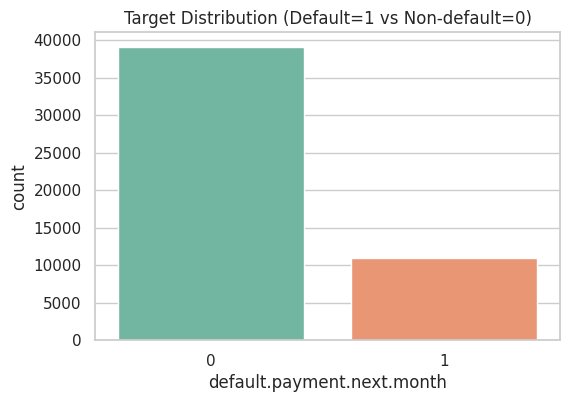

In [8]:
# 2) EDA
# ======================
num_cols_all = df.select_dtypes(include=["number", "bool"]).columns.tolist()
plt.figure(figsize=(6,4))
sns.countplot(x=TARGET, data=df, palette="Set2")
plt.title("Target Distribution (Default=1 vs Non-default=0)")
plt.show()


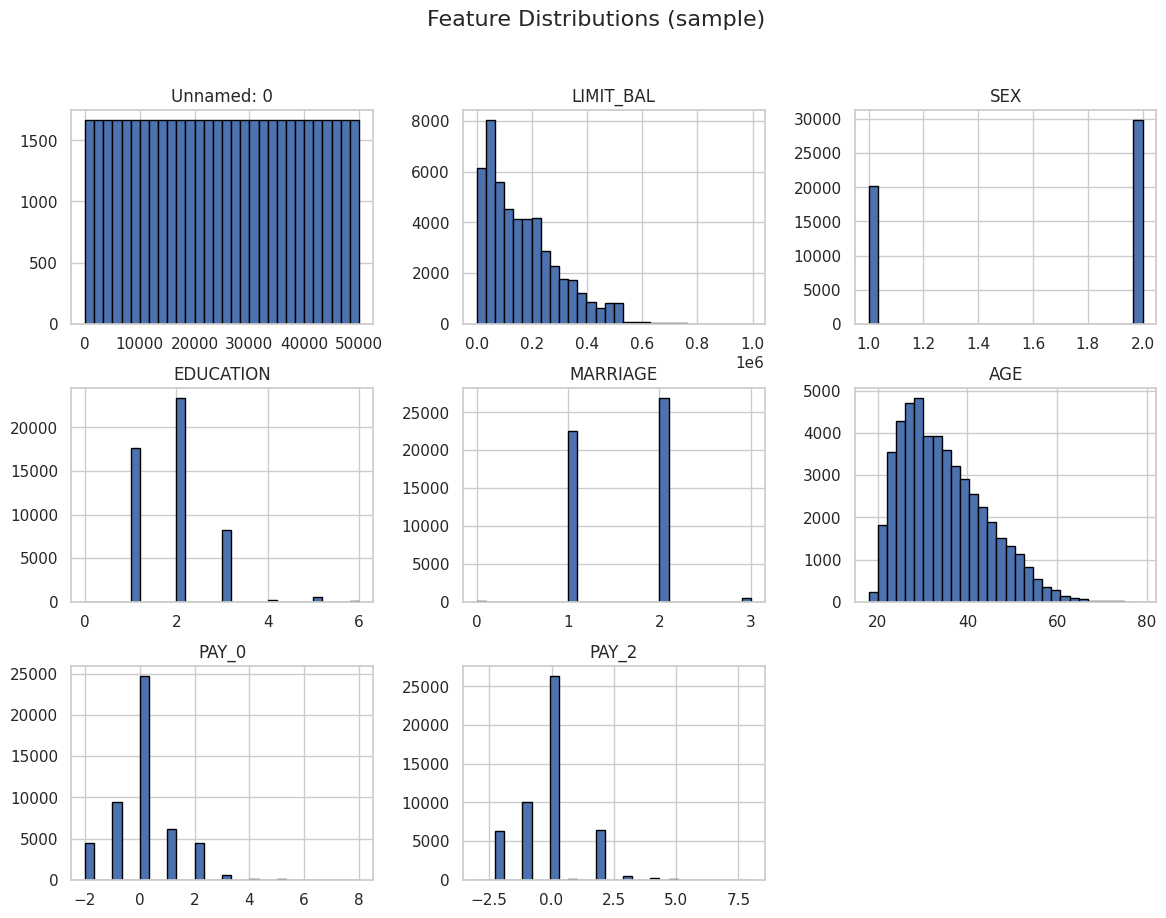

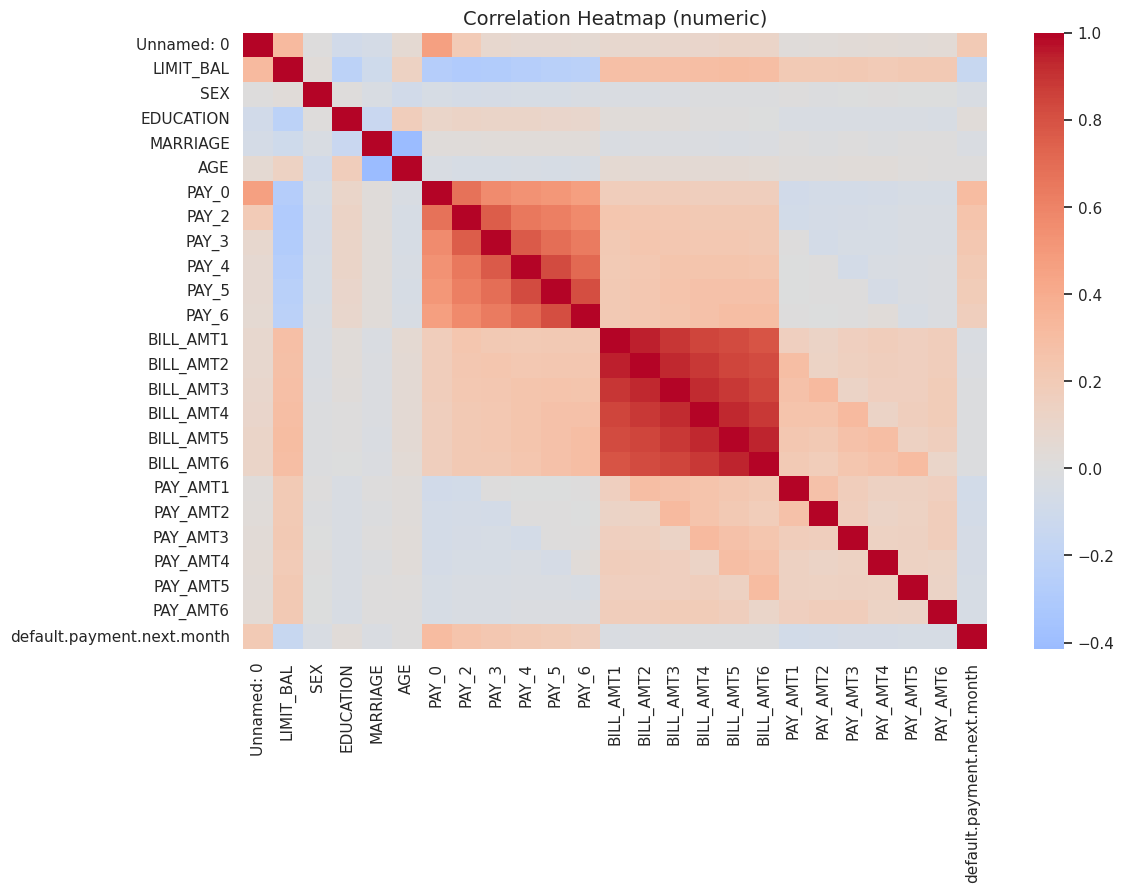

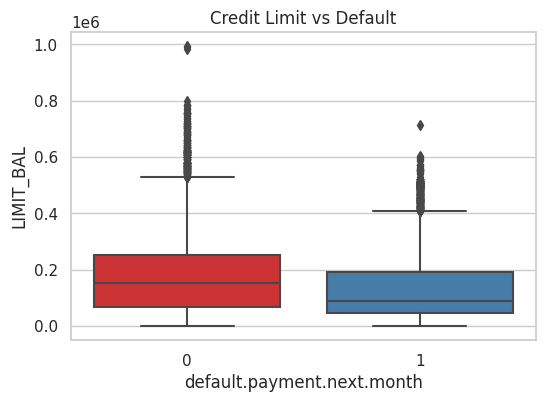

In [9]:
# Distributions (first 8 numeric)
sample_num = [c for c in num_cols_all if c != TARGET][:8]
if sample_num:
    df[sample_num].hist(figsize=(14,10), bins=30, edgecolor="black")
    plt.suptitle("Feature Distributions (sample)", fontsize=16)
    plt.show()

# Correlation heatmap (numeric)
if len(num_cols_all) > 1:
    plt.figure(figsize=(12,8))
    corr = df[num_cols_all].corr()
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap (numeric)", fontsize=14)
    plt.show()

# Boxplot example if LIMIT_BAL exists
if "LIMIT_BAL" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=TARGET, y="LIMIT_BAL", data=df, palette="Set1")
    plt.title("Credit Limit vs Default")
    plt.show()

In [10]:
# 3) Feature Engineering (UCI-style columns; created only if source exists)
# ======================
def safe_ratio(n, d):
    return (n) / (d.replace(0, np.nan))  # avoid division by zero

fe_df = df.copy()

# Ratios for the most recent month (1)
if set(["BILL_AMT1", "PAY_AMT1", "LIMIT_BAL"]).issubset(fe_df.columns):
    fe_df["PAY_RATIO_1"] = (fe_df["PAY_AMT1"] + 1) / (fe_df["BILL_AMT1"] + 1)
    fe_df["BALANCE_RATIO_1"] = fe_df["BILL_AMT1"] / (fe_df["LIMIT_BAL"] + 1)
    fe_df["UTILIZATION_1"] = fe_df["BILL_AMT1"] / (fe_df["LIMIT_BAL"] + 1)

# Trend features: change in bill & payment (1-6)
for i in range(1, 6):
    b1, b2 = f"BILL_AMT{i}", f"BILL_AMT{i+1}"
    p1, p2 = f"PAY_AMT{i}", f"PAY_AMT{i+1}"
    if b1 in fe_df.columns and b2 in fe_df.columns:
        fe_df[f"BILL_DIFF_{i+1}{i}"] = fe_df[b1] - fe_df[b2]
    if p1 in fe_df.columns and p2 in fe_df.columns:
        fe_df[f"PAY_DIFF_{i+1}{i}"] = fe_df[p1] - fe_df[p2]


In [11]:
# Aggregate recent behavior
bill_cols = [f"BILL_AMT{i}" for i in range(1,7) if f"BILL_AMT{i}" in fe_df.columns]
pay_cols  = [f"PAY_AMT{i}"  for i in range(1,7) if f"PAY_AMT{i}"  in fe_df.columns]
if bill_cols:
    fe_df["BILL_MEAN"] = fe_df[bill_cols].mean(axis=1)
    fe_df["BILL_STD"]  = fe_df[bill_cols].std(axis=1)
if pay_cols:
    fe_df["PAY_MEAN"] = fe_df[pay_cols].mean(axis=1)
    fe_df["PAY_STD"]  = fe_df[pay_cols].std(axis=1)

# PAY_X (status) count of delays if present (e.g., PAY_0..PAY_6)
pay_status_cols = [c for c in fe_df.columns if c.startswith("PAY_")]
if pay_status_cols:
    fe_df["PAY_LATE_COUNT"] = (fe_df[pay_status_cols] > 0).sum(axis=1)


In [12]:
# 4) Train/Test split & preprocessing
# ======================
# Drop ID if exists
id_cols = [c for c in fe_df.columns if c.upper() in {"ID", "CUSTOMER_ID"}]
X = fe_df.drop(columns=[TARGET] + id_cols)
y = fe_df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (39999, 42) (10000, 42)


In [13]:
# Column types
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

In [14]:
# Preprocessors
pre_tree = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ],
    remainder="drop"
)
pre_lr = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder="drop"
)

In [16]:
# 5) Baseline Logistic Regression (for reference)
# ======================
logreg = LogisticRegression(
    max_iter=2000, class_weight="balanced", solver="saga", random_state=RANDOM_STATE, n_jobs=-1
)
pipe_lr = Pipeline([("preprocess", pre_lr), ("model", logreg)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy":"accuracy","precision":"precision","recall":"recall","f1":"f1","roc_auc":"roc_auc"}
cv_lr = cross_validate(pipe_lr, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print("\n=== Logistic Regression — 5-Fold CV (Train) ===")
for m in ["accuracy","precision","recall","f1","roc_auc"]:
    print(f"{m:>9}: {cv_lr['test_'+m].mean():.4f} ± {cv_lr['test_'+m].std():.4f}")

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]
print("\n=== Logistic Regression — Test ===")
print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))



=== Logistic Regression — 5-Fold CV (Train) ===
 accuracy: 0.7314 ± 0.0040
precision: 0.4171 ± 0.0061
   recall: 0.5800 ± 0.0095
       f1: 0.4852 ± 0.0064
  roc_auc: 0.7242 ± 0.0067

=== Logistic Regression — Test ===
              precision    recall  f1-score   support

           0     0.8682    0.7791    0.8212      7818
           1     0.4212    0.5761    0.4866      2182

    accuracy                         0.7348     10000
   macro avg     0.6447    0.6776    0.6539     10000
weighted avg     0.7706    0.7348    0.7482     10000

ROC-AUC: 0.7246106367148691


In [17]:
# 6) XGBoost (tuned) — main model to increase accuracy/AUC
# ======================
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=RANDOM_STATE,
    nthread=-1,
    tree_method="hist"  # fast on CPU
)

pipe_xgb = Pipeline([("preprocess", pre_tree), ("model", xgb_base)])

param_dist = {
    "model__n_estimators": [300, 500, 800, 1000],
    "model__learning_rate": [0.02, 0.05, 0.1],
    "model__max_depth": [3, 4, 5, 6, 8],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__gamma": [0, 0.1, 0.3, 0.5]
}

tuner = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist,
    n_iter=40,  # increase for deeper search
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

tuner.fit(X_train, y_train)
print("\n=== XGBoost — Best CV Params ===")
for k, v in tuner.best_params_.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits

=== XGBoost — Best CV Params ===
  model__subsample: 1.0
  model__n_estimators: 800
  model__min_child_weight: 5
  model__max_depth: 8
  model__learning_rate: 0.05
  model__gamma: 0.1
  model__colsample_bytree: 0.6


In [18]:
# Evaluate tuned XGB on test
best_xgb = tuner.best_estimator_
y_proba = best_xgb.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
roc  = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("\n=== XGBoost (Tuned) — Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1       : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")
print(f"PR-AUC   : {pr_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))



=== XGBoost (Tuned) — Test Metrics ===
Accuracy : 0.8438
Precision: 0.7488
Recall   : 0.4276
F1       : 0.5443
ROC-AUC  : 0.8428
PR-AUC   : 0.6614

Classification Report:
               precision    recall  f1-score   support

           0     0.8573    0.9600    0.9057      7818
           1     0.7488    0.4276    0.5443      2182

    accuracy                         0.8438     10000
   macro avg     0.8031    0.6938    0.7250     10000
weighted avg     0.8336    0.8438    0.8269     10000



In [19]:
# 7) Threshold tuning (maximize F1 on validation-from-test example)
# ======================
prec_curve, rec_curve, thr = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (prec_curve * rec_curve) / (prec_curve + rec_curve + 1e-12)
best_idx = np.nanargmax(f1_scores[:-1])  # last threshold is inf
best_thr = thr[best_idx]
print(f"\nBest threshold by F1 on test (demo): {best_thr:.3f}")

y_pred_thr = (y_proba >= best_thr).astype(int)
print("\n=== XGBoost (Tuned) — Test @ best F1 threshold ===")
print(classification_report(y_test, y_pred_thr, digits=4))



Best threshold by F1 on test (demo): 0.255

=== XGBoost (Tuned) — Test @ best F1 threshold ===
              precision    recall  f1-score   support

           0     0.8974    0.8695    0.8833      7818
           1     0.5794    0.6439    0.6099      2182

    accuracy                         0.8203     10000
   macro avg     0.7384    0.7567    0.7466     10000
weighted avg     0.8280    0.8203    0.8236     10000



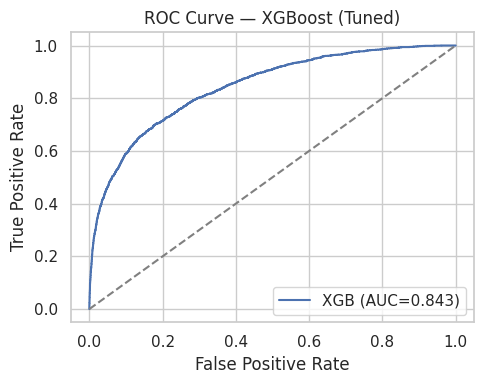

In [21]:
# 8) Plots: ROC, PR, Confusion Matrix
# ======================
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"XGB (AUC={roc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost (Tuned)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


<Figure size 500x400 with 0 Axes>

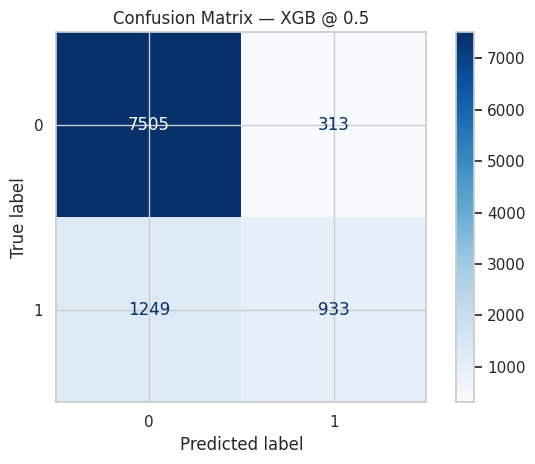

<Figure size 500x400 with 0 Axes>

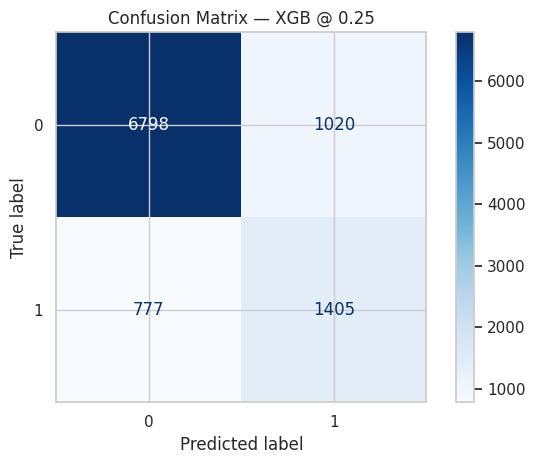

In [22]:
# Confusion Matrix @ 0.5 and @ best_thr
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(5,4))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(y_test, y_pred, "Confusion Matrix — XGB @ 0.5")
plot_cm(y_test, y_pred_thr, f"Confusion Matrix — XGB @ {best_thr:.2f}")